In [5]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifftshift, fft2, ifft2

Motion-corrupted image saved to: sub-01_T1w_motion.nii.gz


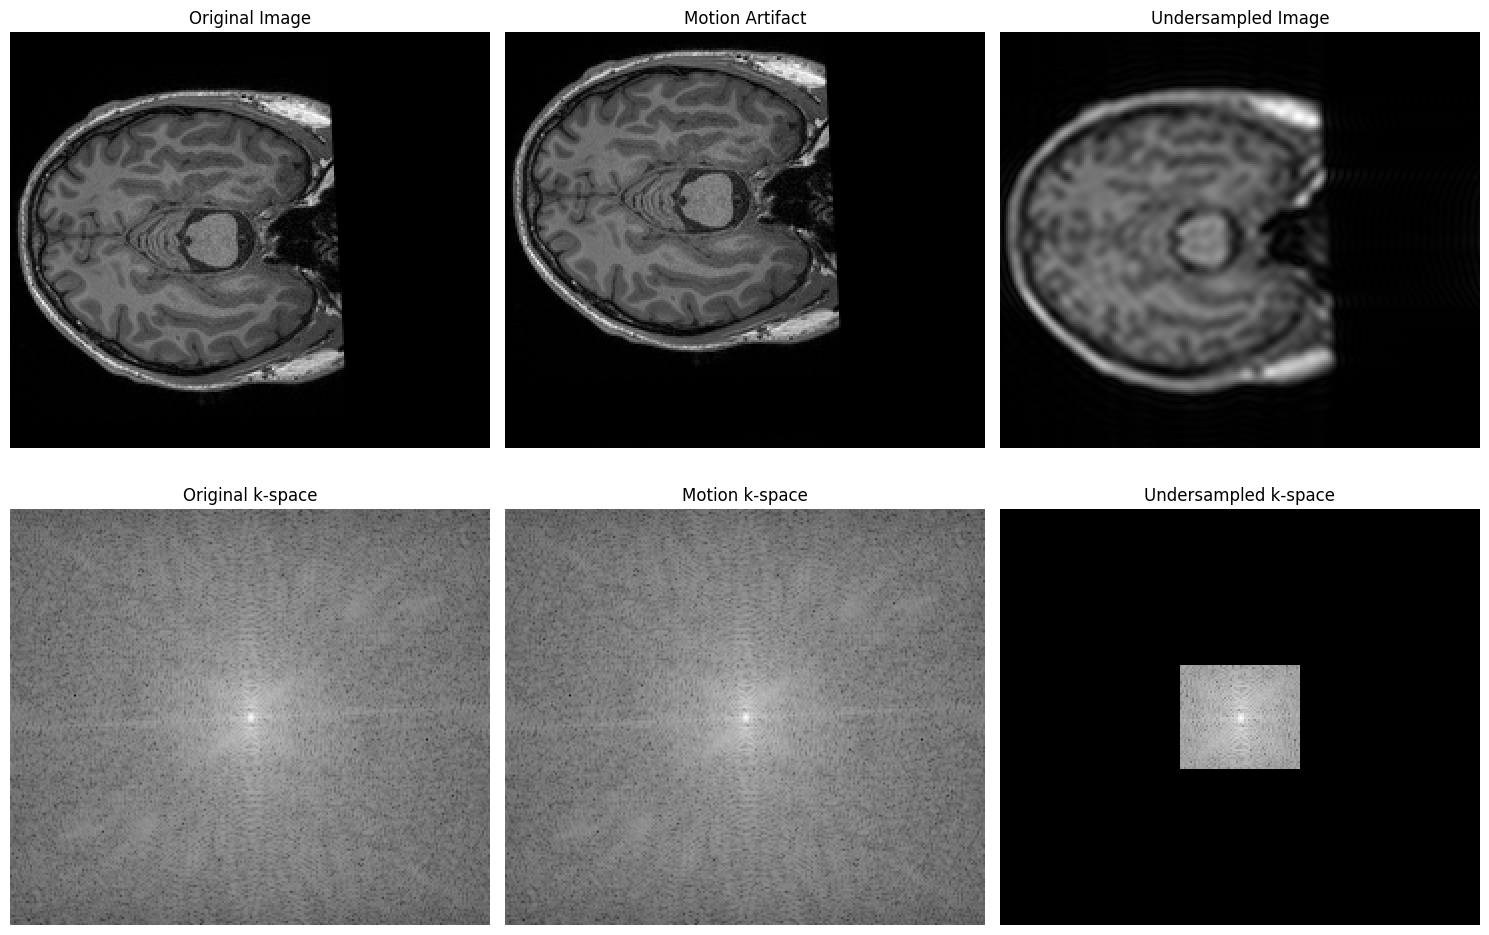

In [6]:


def load_nifti_image(file_path):
    """Load a NIfTI image and return the data as a numpy array."""
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

def apply_fourier_transform(image):
    """Convert an image to k-space using the Fourier transform."""
    k_space = fftshift(fft2(image))
    return k_space

def apply_inverse_fourier_transform(k_space):
    """Convert k-space back to the image domain using the inverse Fourier transform."""
    image = np.abs(ifft2(ifftshift(k_space)))
    return image

def add_motion_artifact(k_space, shift=10):
    """Simulate motion artifact by introducing phase shifts in k-space."""
    rows, cols = k_space.shape
    for i in range(rows):
        k_space[i, :] *= np.exp(1j * 2 * np.pi * shift * i / rows)
    return k_space

def undersample_k_space(k_space, factor=2):
    """Simulate undersampling by zeroing out parts of k-space."""
    mask = np.zeros_like(k_space)
    center_fraction = 1 / factor
    center_rows = int(k_space.shape[0] * center_fraction)
    center_cols = int(k_space.shape[1] * center_fraction)
    center_start_row = k_space.shape[0] // 2 - center_rows // 2
    center_start_col = k_space.shape[1] // 2 - center_cols // 2
    mask[center_start_row:center_start_row + center_rows, center_start_col:center_start_col + center_cols] = 1
    undersampled_k_space = k_space * mask
    return undersampled_k_space

def visualize_results(original, motion_artifact, undersampled, k_space_orig, k_space_motion, k_space_under):
    """Visualize the original, motion artifact, and undersampled images along with their k-spaces."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Image domain (top row)
    axes[0,0].imshow(original, cmap='gray')
    axes[0,0].set_title("Original Image")
    axes[0,0].axis('off')

    axes[0,1].imshow(motion_artifact, cmap='gray')
    axes[0,1].set_title("Motion Artifact")
    axes[0,1].axis('off')

    axes[0,2].imshow(undersampled, cmap='gray')
    axes[0,2].set_title("Undersampled Image")
    axes[0,2].axis('off')

    # K-space visualization (bottom row)
    # Log scale for better visualization
    axes[1,0].imshow(np.log(np.abs(k_space_orig) + 1), cmap='gray')
    axes[1,0].set_title("Original k-space")
    axes[1,0].axis('off')

    axes[1,1].imshow(np.log(np.abs(k_space_motion) + 1), cmap='gray')
    axes[1,1].set_title("Motion k-space")
    axes[1,1].axis('off')

    axes[1,2].imshow(np.log(np.abs(k_space_under) + 1), cmap='gray')
    axes[1,2].set_title("Undersampled k-space")
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

def apply_3d_motion_artifact(image_3d, shift=10):
    """Apply motion artifact to each slice of a 3D volume."""
    motion_image = np.zeros_like(image_3d, dtype=complex)
    
    # Apply motion artifact slice by slice
    for z in range(image_3d.shape[2]):
        # Convert slice to k-space
        k_space = apply_fourier_transform(image_3d[:, :, z])
        # Apply motion artifact
        k_space_motion = add_motion_artifact(k_space, shift=shift)
        # Convert back to image space
        motion_image[:, :, z] = ifft2(ifftshift(k_space_motion))
    
    # Return magnitude of complex data
    return np.abs(motion_image)

def main():
    # Path to your NIfTI file
    file_path = "sub-01_T1w.nii.gz"
    output_path = "sub-01_T1w_motion.nii.gz"

    # Load the original NIfTI image
    img = nib.load(file_path)
    image_data = img.get_fdata()
    
    # Apply motion artifact to full 3D volume
    motion_image_3d = apply_3d_motion_artifact(image_data, shift=20)  # Increased shift for more visible effect
    
    # Get middle slice
    middle_slice = image_data.shape[2] // 2
    
    # Create k-space of middle slice
    k_space_middle = apply_fourier_transform(image_data[:, :, middle_slice])
    
    # Apply undersampling to middle slice
    undersampled_k_space = undersample_k_space(k_space_middle, factor=4)  # Increased factor for more visible effect
    undersampled_image = apply_inverse_fourier_transform(undersampled_k_space)
    
    # Create new NIfTI image with same header as original
    motion_nifti = nib.Nifti1Image(motion_image_3d, img.affine, img.header)
    
    # Save the motion-corrupted image
    nib.save(motion_nifti, output_path)
    print(f"Motion-corrupted image saved to: {output_path}")
    
    # Visualize results
    visualize_results(
        image_data[:, :, middle_slice],  # original middle slice
        motion_image_3d[:, :, middle_slice],  # motion-corrupted middle slice
        undersampled_image,  # now using actual undersampled image
        k_space_middle,  # original k-space
        apply_fourier_transform(motion_image_3d[:, :, middle_slice]),  # motion k-space
        undersampled_k_space  # undersampled k-space
    )


if __name__ == "__main__":
    main()